# **🔴ENVIRONMENT SETUP**

In [ ]:
!pip install -q torchmetrics
!pip install -q wandb
!pip install -q fastai
!pip install -q pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 7.1 MB/s eta 0:00:00


# **🔴IMPORT LIBS**

In [ ]:
# Load the necessary libraries
from google.colab import files
from IPython.display import display, Math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torchvision
from torchvision import transforms as TT
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim
from torch.nn import functional as F
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence

from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import wandb
import tqdm
import torchmetrics as tm
from torchmetrics import Metric
from PIL import Image

from argparse import Namespace
from typing import List, Optional, Set

import editdistance
from pathlib import Path

from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers.wandb import WandbLogger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **🔴ARGUMENTS**

In [ ]:
# Define configuration parameters

config = {
    "seed": 1234,

    "trainer": {
        "overfit_batches": 0.0,
        "check_val_every_n_epoch": 2,
        "fast_dev_run": False,
        "max_epochs": 100,
        "min_epochs": 1,
        "num_sanity_val_steps": 0,
    },

    "callbacks": {
        "model_checkpoint": {
            "save_top_k": 1,
            "save_weights_only": True,
            "mode": "min",
            "monitor": "val/loss",
            "dirpath": "/content/drive/MyDrive/papersFolder/model_checkpoints",
            "filename": "{epoch}-{val/loss:.2f}-{val/cer:.2f}"
        },
        "early_stopping": {
            "patience": 3,
            "mode": "min",
            "monitor": "val/loss",
            "min_delta": 0.001
        },
        "LearningRateMonitor":{
            "logging_interval": "epoch"
        }
    },

    "data": {
        "batch_size": 16,
        "num_workers": 4,
        "pin_memory": True
    },

    "lit_model": {
        # Optimizer
        "lr": 0.0001,
        "weight_decay": 0.00001,

        # Scheduler
        "milestones": [10],
        "gamma": 0.5,

        # Model
        "d_model": 128,
        "dim_feedforward": 256,
        "nhead": 4,
        "dropout": 0,
        "num_decoder_layers": 3,
        "max_output_len": 200
    },

    "logger": {
        "project": "image-to-latex"
    }
}

In [ ]:
path = '/content/drive/MyDrive/papersFolder/'

# **🔴CUSTOM DATASET**

In [ ]:
# Prepare LaTeX formulas for custom tokenizer

df = pd.read_csv(os.path.join(path, 'merged_sorted.csv'))
latex_formulas = df.iloc[:, 1]
with open(os.path.join(path, 'latex_formulas.txt'), 'w', encoding='utf-8') as f:
  for formula in latex_formulas:
    f.write(formula + '\n')

print('Done!')

Done!


In [ ]:
# Define tokens for LaTeX
tokens = [
    '\\', '{', '}', '^', '+', '-', "'", '_', '!', '.', '/', '&', '%', '*', '\\div', '\\geq',
    '\\leq', '\\frac', '\\times', '\\lim', '\\sin', '\\cos', '\\tan', '\\csc', '\\sec',
    '\\sqrt', '\\sum', '\\rightarrow', '\\Rightarrow', '\\leftarrow', '\\Leftarrow',
    '\\right', '\\left', '\\alpha', '\\beta', '|', '\\Delta', '\\delta', '\\gamma', '\\lambda',
    '\\min', '\\max', '(', ')', '<', '>', '=', '\\pm', '\\mp', '\\neq', '\\infty', 'matrix',
    '[', ']', '\\in', '\\notin', '\\cap', '\\cup', '\\begin', '\\end', '\\dots', '\\int', ':',
    '\\ln', '\\pi', '\\theta', '\\to', '\\arctan', '\\arccot', '\\arcsin', '\\arccos',
    '\\log', '\\sinh', '\\cosh', '\\coth', '\\tanh', '\\degree', '\\sim',
    '\\forall', '\\emptyset', '\\buildrelF', '\\bar', '\\exists', '\\varepsilon', '\\partial',
    '\\hat', '\\triangle', '\\mathbb', '\\simeq',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
]
# Train tokenizer
tokenizer = Tokenizer(models.BPE())

special_tokens = ["<s>", "</s>", "<unk>", "<pad>"] + tokens
trainer = trainers.BpeTrainer(vocab_size=len(special_tokens), special_tokens=special_tokens)

tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

files = ["/content/drive/MyDrive/papersFolder/latex_formulas.txt"]
tokenizer.train(files, trainer)

# Save the trained tokenizer
tokenizer.save("/content/drive/MyDrive/papersFolder/latex_tokenizer.json")

print("✅Done")

✅Done


In [ ]:
def target_transform(label):
  # Tokenize the label with start and end tokens
  tokenizer = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
  encoded_label = tokenizer.encode(f'<s>{label}</s>')
  return torch.LongTensor(encoded_label.ids)

In [ ]:
image_transform = TT.Compose([
    # Transform image to grayscale, resize, and normalize
    TT.Grayscale(num_output_channels=1),
    TT.Resize((256, 512)),
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
class LatexImages(Dataset):
    _all_cropped_files = None

    def __init__(self, path, phase, image_transform=None, target_transform=None):
        self.path = path
        self.image_transform = image_transform
        self.target_transform = target_transform
        self.phase = phase

        csv = pd.read_csv(os.path.join(self.path, 'merged_sorted.csv'))

        self.image_paths = []
        self.labels = []

        # Process the "cropped" folder
        if LatexImages._all_cropped_files is None:
            cropped_folder = os.path.join(self.path, 'cropped')
            LatexImages._all_cropped_files = os.listdir(cropped_folder)
            random.shuffle(LatexImages._all_cropped_files)

        if phase == 'train':
            start, end = 0, 5600
        elif phase == 'valid':
            start, end = 5600, 6600
        else:  # test
            start, end = 6600, 7000

        selected_files = LatexImages._all_cropped_files[start:end]

        for i in selected_files:
            image_path = fr'.\cropped\{i}'
            try:
                label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
                self.image_paths.append(image_path)
                self.labels.append(label)
            except:
                print(f"Image not found in CSV: {image_path}")

        # Process other folders
        for folder in ['Symbols', 'EnglishAlphabet', 'PersianNumbers']:
            folder_path = os.path.join(self.path, folder)
            extra_files = []  # Clear list on each iteration

            for subfolder in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder)
                for fil in os.listdir(subfolder_path):
                    extra_files.append(fr'.\{folder}\{subfolder}\{fil}')

            random.shuffle(extra_files)
            total_count = len(extra_files)
            train_count = int(0.8 * total_count)
            valid_count = int(0.2 * total_count)

            if phase == 'train':
                selected_files = extra_files[:train_count]
            elif phase == 'valid':
                selected_files = extra_files[train_count:train_count + valid_count]
            else:
                selected_files = extra_files[train_count + valid_count:]

            for image_path in selected_files:
                try:
                    label = csv[csv['Image Path'] == image_path]['LaTeX Label'].values[0]
                    self.image_paths.append(image_path)
                    self.labels.append(label)
                except:
                    pass

    def __getitem__(self, index):
        try:
          image_path = os.path.join(self.path, self.image_paths[index].split('\\')[1], self.image_paths[index].split('\\')[2], self.image_paths[index].split('\\')[3])
        except:
          image_path = os.path.join(self.path, self.image_paths[index].split('\\')[1], self.image_paths[index].split('\\')[2])

        # Apply target transformation if specified
        if self.target_transform:
            label = self.target_transform(self.labels[index])
        else:
            label = self.labels[index]

        # Open the image and apply transformations
        image = Image.open(image_path)
        if self.image_transform:
            image = self.image_transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)


In [ ]:
train_dataset = LatexImages(path=path, phase="train", image_transform=image_transform, target_transform=target_transform)
valid_dataset = LatexImages(path=path, phase="valid", image_transform=image_transform, target_transform=target_transform)
test_dataset = LatexImages(path=path, phase="test", image_transform=image_transform, target_transform=target_transform)

print(len(train_dataset))  # 4000 + other folders
print(len(valid_dataset))  # 1500 + other folders
print(len(test_dataset))  # 1500


20943
4834
362


torch.Size([1, 256, 512]) torch.Size([20])


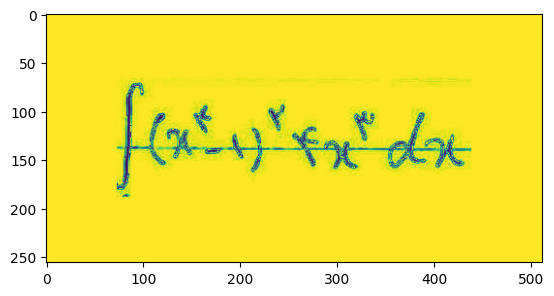

In [ ]:
im, la = train_dataset.__getitem__(np.random.randint(0, train_dataset.__len__()))

plt.imshow(TT.ToPILImage()(im))
print(im.shape, la.shape)

# **🔴Analize the dataset**

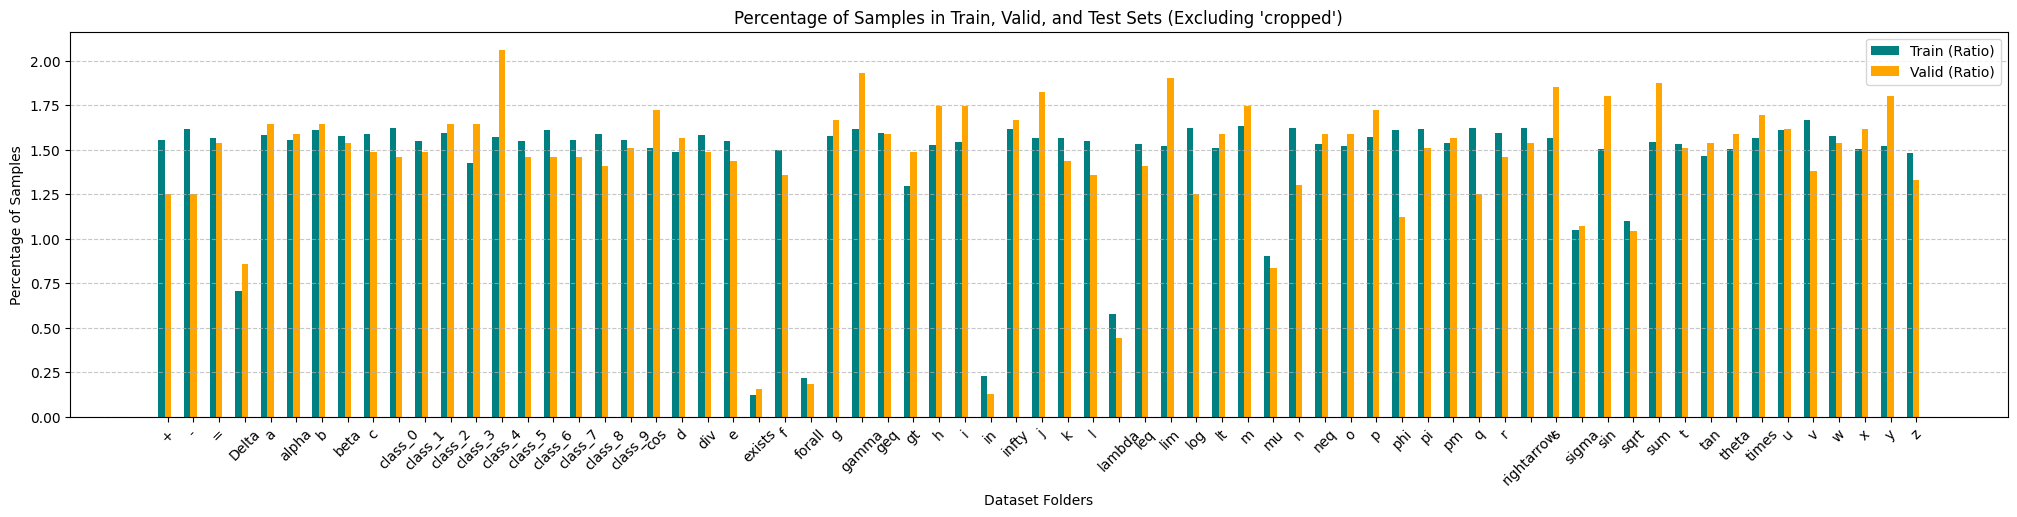

In [ ]:
def count_samples(dataset):
    folder_counts = defaultdict(int)
    # Count the number of samples in each folder based on image paths
    for image_path in dataset.image_paths:
        folder_name = image_path.split('\\')[-2]
        folder_counts[folder_name] += 1
    return folder_counts

# Get the sample counts for the train and validation datasets
train_counts = count_samples(train_dataset)
valid_counts = count_samples(valid_dataset)

# Exclude "cropped" folder from the list of folders
all_folders = sorted(set(train_counts.keys()) | set(valid_counts.keys()))
all_folders = [folder for folder in all_folders if folder != "cropped"]

# Extract sample counts and compute ratios (0 if no value exists for a folder)
train_values = [train_counts.get(folder, 0) for folder in all_folders]
valid_values = [valid_counts.get(folder, 0) for folder in all_folders]
# Calculate ratios as percentages
total_train = sum(train_values)
total_valid = sum(valid_values)
train_ratios = [count / total_train * 100 if total_train != 0 else 0 for count in train_values]
valid_ratios = [count / total_valid * 100 if total_valid != 0 else 0 for count in valid_values]

# Chart settings
x = np.arange(len(all_folders))  # Positions for x-axis labels
width = 0.25  # Bar width

plt.figure(figsize=(25, 5))

# Plot the bars for the ratios
plt.bar(x - width, train_ratios, width, label='Train (Ratio)', color='teal')
plt.bar(x, valid_ratios, width, label='Valid (Ratio)', color='orange')

# Configure chart
plt.xlabel("Dataset Folders")
plt.ylabel("Percentage of Samples")
plt.title("Percentage of Samples in Train, Valid, and Test Sets (Excluding 'cropped')")
plt.xticks(ticks=x, labels=all_folders, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.show()


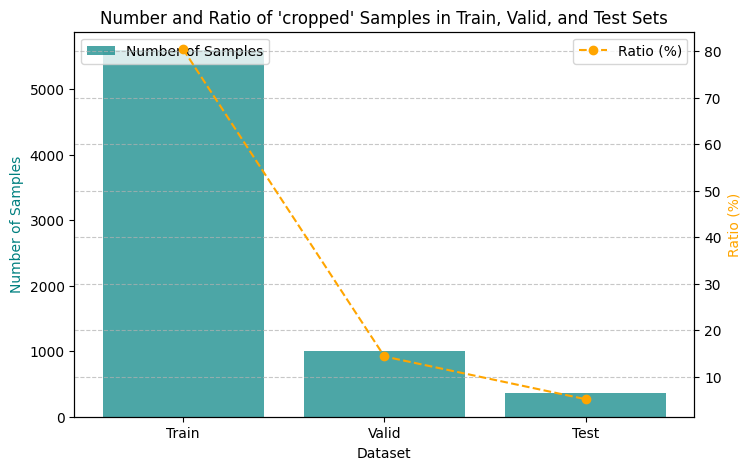

In [ ]:
def count_cropped_samples(dataset):
    folder_counts = defaultdict(int)
    # Only consider the "cropped" folder for counting samples
    for image_path in dataset.image_paths:
        folder_name = image_path.split('\\')[-2]
        if folder_name == "cropped":  # Only count samples in the "cropped" folder
            folder_counts[folder_name] += 1
    return folder_counts

# Get the sample counts for the "cropped" folder in train, valid, and test datasets
train_cropped_counts = count_cropped_samples(train_dataset)
valid_cropped_counts = count_cropped_samples(valid_dataset)
test_cropped_counts = count_cropped_samples(test_dataset)

# Number of samples in "cropped" folder
train_cropped_value = train_cropped_counts.get("cropped", 0)
valid_cropped_value = valid_cropped_counts.get("cropped", 0)
test_cropped_value = test_cropped_counts.get("cropped", 0)

# Calculate ratios
total_train = train_cropped_value + valid_cropped_value + test_cropped_value
train_ratio = (train_cropped_value / total_train * 100) if total_train != 0 else 0
valid_ratio = (valid_cropped_value / total_train * 100) if total_train != 0 else 0
test_ratio = (test_cropped_value / total_train * 100) if total_train != 0 else 0

# Chart settings
x = ['Train', 'Valid', 'Test']
values = [train_cropped_value, valid_cropped_value, test_cropped_value]
ratios = [train_ratio, valid_ratio, test_ratio]

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar chart for the number of samples
ax1.bar(x, values, color='teal', alpha=0.7, label="Number of Samples")

# Plotting the ratios with a secondary y-axis
ax2 = ax1.twinx()  # Create a second axis for the ratios
ax2.plot(x, ratios, color='orange', marker='o', label="Ratio (%)", linestyle='--')

# Chart configurations
ax1.set_xlabel("Dataset")
ax1.set_ylabel("Number of Samples", color='teal')
ax2.set_ylabel("Ratio (%)", color='orange')
ax1.set_title("Number and Ratio of 'cropped' Samples in Train, Valid, and Test Sets")

# Display legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **🔴Data Loader**

In [ ]:
def collate_fn(data):
    # Load the tokenizer and get the padding token value
    token = Tokenizer.from_file(f"{path}/latex_tokenizer.json")
    pad_value = token.get_vocab().get('<pad>', 3)

    tensors, targets = zip(*data)

    # Convert targets into tensors
    targets = [torch.tensor(t, dtype=torch.long) for t in targets]

    # Pad sequences to ensure equal length within a batch
    features = pad_sequence(targets, padding_value=pad_value, batch_first=True)

    try:
        # Stack tensors to create a batch
        tensors = torch.stack(tensors)
    except RuntimeError as e:
        # Print an error message if stacking fails
        print(f"stack error: {e}")
        for i, t in enumerate(tensors):
            print(f"tensor shape error {i}: {t.shape}")

    return tensors, features


In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn, **config['data'])
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=collate_fn, **config['data'])
test_loader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn, **config['data'])

In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([16, 1, 256, 512]), torch.Size([16, 25]))

# **🔴Metric**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class CharacterErrorRate(Metric):
    def __init__(self, ignore_indices: Set[int], *args):
        # Initialize the Metric class and set the ignore indices for certain tokens
        super().__init__(*args)
        self.ignore_indices = ignore_indices

        # Track the total errors and the number of samples processed
        self.add_state("error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

        self.error: Tensor
        self.total: Tensor

    def update(self, preds, targets):
        N = preds.shape[0]

        for i in range(N):
            # Filter out ignored indices from both prediction and target
            pred = [token for token in preds[i].tolist() if token not in self.ignore_indices]
            target = [token for token in targets[i].tolist() if token not in self.ignore_indices]

            # Compute the edit distance (Levenshtein distance) between prediction and target
            distance = editdistance.distance(pred, target)

            # Update error count based on the relative length of the prediction and target
            if max(len(pred), len(target)) > 0:
                self.error += distance / max(len(pred), len(target))

        # Increment total processed samples
        self.total += N

    def compute(self) -> Tensor:
        # Return the average character error rate
        return self.error / self.total


# **🔴Functions**

In [ ]:
class LitResNetTransformer(LightningModule):
    def __init__(self,
                 d_model: int,
                 dim_feedforward: int,
                 nhead: int,
                 dropout: float,
                 num_decoder_layers: int,
                 max_output_len: int,
                 lr: float = 0.001,
                 weight_decay: float = 0.0001,
                 milestones: List[int] = [5],
                 gamma: float = 0.1,
                 save_path: str = 'path_to_save'):  # Default save path for model
        super().__init__()
        self.save_hyperparameters()
        self.tokenizer = Tokenizer.from_file(f"{self.path}/latex_tokenizer.json")  # Load tokenizer
        self.model = ResNetTransformer(  # Initialize ResNet-Transformer model
            d_model=d_model,
            dim_feedforward=dim_feedforward,
            nhead=nhead,
            dropout=dropout,
            num_decoder_layers=num_decoder_layers,
            max_output_len=max_output_len,
            sos_index=self.tokenizer.get_vocab()["<s>"],  # Start-of-sequence token
            eos_index=self.tokenizer.get_vocab()["</s>"],  # End-of-sequence token
            pad_index=self.tokenizer.get_vocab()["<pad>"],  # Padding token
            num_classes=self.tokenizer.get_vocab_size(),  # Number of classes
        )
        # Cross-Entropy loss ignoring padding
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=self.tokenizer.get_vocab()["<pad>"])
        self.val_cer = CharacterErrorRate({self.tokenizer.get_vocab()["<pad>"], self.tokenizer.get_vocab()["<s>"], self.tokenizer.get_vocab()["</s>"]})  # CER for validation
        self.test_cer = CharacterErrorRate({self.tokenizer.get_vocab()["<pad>"], self.tokenizer.get_vocab()["<s>"], self.tokenizer.get_vocab()["</s>"]})  # CER for testing

    def training_step(self, batch, batch_idx):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])  # Model output excluding last target token
        loss = self.loss_fn(logits, targets[:, 1:])  # Compute loss excluding first target token
        self.log("train/loss", loss)  # Log training loss
        return loss

    def validation_step(self, batch):
        imgs, targets = batch
        logits = self.model(imgs, targets[:, :-1])  # Model output
        loss = self.loss_fn(logits, targets[:, 1:])  # Compute loss
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)  # Log validation loss

        preds = self.model.predict(imgs)  # Get predictions
        val_cer = self.val_cer(preds, targets)  # Compute CER for validation
        self.log("val/cer", val_cer)

    def test_step(self, batch):
        imgs, targets = batch
        preds = self.model.predict(imgs)  # Get predictions
        test_cer = self.test_cer(preds, targets)  # Compute CER for test
        self.log("test/cer", test_cer)  # Log test CER
        self.test_step_outputs.append(preds)  # Store predictions
        return preds

    def on_test_epoch_end(self):
        with open(f"{self.path}/test_predictions.txt", "w") as f:  # Save predictions to file
            for preds in self.test_step_outputs:
                for pred in preds:
                    decoded = [self.tokenizer.id_to_token(j) for j in pred.tolist() if j != 3]  # Decode predictions
                    decoded.append("\n")
                    f.write(" ".join(decoded))  # Write to file

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)  # AdamW optimizer
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)  # Learning rate scheduler
        return [optimizer], [scheduler]


# **🔴Model**

In [ ]:
class PositionalEncoding2D(nn.Module):
    """2-D positional encodings for the feature maps produced by the encoder.

    Following https://arxiv.org/abs/2103.06450 by Sumeet Singh.

    Reference:
    https://github.com/full-stack-deep-learning/fsdl-text-recognizer-2021-labs/blob/main/lab9/text_recognizer/models/transformer_util.py
    """

    def __init__(self, d_model: int, max_h: int = 2000, max_w: int = 2000) -> None:
        super().__init__()
        self.d_model = d_model
        assert d_model % 2 == 0, f"Embedding depth {d_model} is not even"
        pe = self.make_pe(d_model, max_h, max_w)  # (d_model, max_h, max_w)
        self.register_buffer("pe", pe)

    @staticmethod
    def make_pe(d_model: int, max_h: int, max_w: int) -> Tensor:
        """Compute positional encoding."""
        pe_h = PositionalEncoding1D.make_pe(d_model=d_model // 2, max_len=max_h)  # (max_h, 1 d_model // 2)
        pe_h = pe_h.permute(2, 0, 1).expand(-1, -1, max_w)  # (d_model // 2, max_h, max_w)

        pe_w = PositionalEncoding1D.make_pe(d_model=d_model // 2, max_len=max_w)  # (max_w, 1, d_model // 2)
        pe_w = pe_w.permute(2, 1, 0).expand(-1, max_h, -1)  # (d_model // 2, max_h, max_w)

        pe = torch.cat([pe_h, pe_w], dim=0)  # (d_model, max_h, max_w)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (B, d_model, H, W)

        Returns:
            (B, d_model, H, W)
        """
        assert x.shape[1] == self.pe.shape[0]  # type: ignore
        x = x + self.pe[:, : x.size(2), : x.size(3)]  # type: ignore
        return x


class PositionalEncoding1D(nn.Module):
    """Classic Attention-is-all-you-need positional encoding."""

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = self.make_pe(d_model, max_len)  # (max_len, 1, d_model)
        self.register_buffer("pe", pe)

    @staticmethod
    def make_pe(d_model: int, max_len: int) -> Tensor:
        """Compute positional encoding."""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        return pe

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (S, B, d_model)

        Returns:
            (B, d_model, H, W)
        """
        assert x.shape[2] == self.pe.shape[2]  # type: ignore
        x = x + self.pe[: x.size(0)]  # type: ignore
        return self.dropout(x)

In [ ]:
from typing import Union

class ResNetTransformer(nn.Module):
    def __init__(
        self,
        d_model: int,
        dim_feedforward: int,
        nhead: int,
        dropout: float,
        num_decoder_layers: int,
        max_output_len: int,
        sos_index: int,
        eos_index: int,
        pad_index: int,
        num_classes: int,
    ) -> None:
        super().__init__()
        self.d_model = d_model
        self.max_output_len = max_output_len + 2
        self.sos_index = sos_index
        self.eos_index = eos_index
        self.pad_index = pad_index

        # Encoder
        resnet = torchvision.models.resnet18(pretrained=False)
        self.backbone = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
        )
        self.bottleneck = nn.Conv2d(256, self.d_model, 1)
        self.image_positional_encoder = PositionalEncoding2D(self.d_model)

        # Decoder
        self.embedding = nn.Embedding(num_classes, self.d_model)
        self.y_mask = generate_square_subsequent_mask(self.max_output_len)
        self.word_positional_encoder = PositionalEncoding1D(self.d_model, max_len=self.max_output_len)
        transformer_decoder_layer = nn.TransformerDecoderLayer(self.d_model, nhead, dim_feedforward, dropout)
        self.transformer_decoder = nn.TransformerDecoder(transformer_decoder_layer, num_decoder_layers)
        self.fc = nn.Linear(self.d_model, num_classes)

        # It is empirically important to initialize weights properly
        if self.training:
            self._init_weights()

    def _init_weights(self) -> None:
        """Initialize weights."""
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-init_range, init_range)

        nn.init.kaiming_normal_(
            self.bottleneck.weight.data,
            a=0,
            mode="fan_out",
            nonlinearity="relu",
        )
        if self.bottleneck.bias is not None:
            _, fan_out = nn.init._calculate_fan_in_and_fan_out(self.bottleneck.weight.data)
            bound = 1 / math.sqrt(fan_out)
            nn.init.normal_(self.bottleneck.bias, -bound, bound)

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        """Forward pass.

        Args:
            x: (B, _E, _H, _W)
            y: (B, Sy) with elements in (0, num_classes - 1)

        Returns:
            (B, num_classes, Sy) logits
        """
        encoded_x = self.encode(x)  # (Sx, B, E)
        output = self.decode(y, encoded_x)  # (Sy, B, num_classes)
        output = output.permute(1, 2, 0)  # (B, num_classes, Sy)
        return output

    def encode(self, x: Tensor) -> Tensor:
        """Encode inputs and extract feature maps for visualization.

        Args:
            x: (B, C, _H, _W) - Input images

        Returns:
            encoded_x: (Sx, B, E) - Encoded sequence from ResNet
            feature_maps: (B, 256, H, W) - Feature maps from ResNet before bottleneck
        """
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # Convert grayscale to 3-channel if needed

        x = self.backbone(x)  # Extract features from ResNet backbone
        feature_maps = x.clone()  # Save feature maps before bottleneck
        x = self.bottleneck(x)  # Apply bottleneck layer
        x = self.image_positional_encoder(x)  # Apply positional encoding
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # Reshape to (Sx, B, E)

        return x, feature_maps

    def decode(self, y: Tensor, encoded_x: Tensor) -> Tensor:
        """Decode encoded inputs with teacher-forcing.

        Args:
            encoded_x: (Sx, B, E)
            y: (B, Sy) with elements in (0, num_classes - 1)

        Returns:
            (Sy, B, num_classes) logits
        """
        y = y.permute(1, 0)  # (Sy, B)
        y = self.embedding(y) * math.sqrt(self.d_model)  # (Sy, B, E)
        y = self.word_positional_encoder(y)  # (Sy, B, E)
        Sy = y.shape[0]
        y_mask = self.y_mask[:Sy, :Sy].type_as(encoded_x)  # (Sy, Sy)
        output = self.transformer_decoder(y, encoded_x, y_mask)  # (Sy, B, E)
        output = self.fc(output)  # (Sy, B, num_classes)
        return output

    def predict(self, x: Tensor) -> Tensor:
        """Make predctions at inference time.

        Args:
            x: (B, C, H, W). Input images.

        Returns:
            (B, max_output_len) with elements in (0, num_classes - 1).
        """
        B = x.shape[0]
        S = self.max_output_len

        encoded_x = self.encode(x)  # (Sx, B, E)

        output_indices = torch.full((B, S), self.pad_index).type_as(x).long()
        output_indices[:, 0] = self.sos_index
        has_ended = torch.full((B,), False)

        for Sy in range(1, S):
            y = output_indices[:, :Sy]  # (B, Sy)
            logits = self.decode(y, encoded_x)  # (Sy, B, num_classes)
            # Select the token with the highest conditional probability
            output = torch.argmax(logits, dim=-1)  # (Sy, B)
            output_indices[:, Sy] = output[-1:]  # Set the last output token

            # Early stopping of prediction loop to speed up prediction
            has_ended |= (output_indices[:, Sy] == self.eos_index).type_as(has_ended)
            if torch.all(has_ended):
                break

        # Set all tokens after end token to be padding
        eos_positions = find_first(output_indices, self.eos_index)
        for i in range(B):
            j = int(eos_positions[i].item()) + 1
            output_indices[i, j:] = self.pad_index

        return output_indices


def generate_square_subsequent_mask(size: int) -> Tensor:
    """Generate a triangular (size, size) mask."""
    mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
    return mask


def find_first(x: Tensor, element: Union[int, float], dim: int = 1) -> Tensor:
    """Find the first occurence of element in x along a given dimension.

    Args:
        x: The input tensor to be searched.
        element: The number to look for.
        dim: The dimension to reduce.

    Returns:
        Indices of the first occurence of the element in x. If not found, return the
        length of x along dim.

    Usage:
        >>> first_element(Tensor([[1, 2, 3], [2, 3, 3], [1, 1, 1]]), 3)
        tensor([2, 1, 3])

    Reference:
        https://discuss.pytorch.org/t/first-nonzero-index/24769/9

        I fixed an edge case where the element we are looking for is at index 0. The
        original algorithm will return the length of x instead of 0.
    """
    mask = x == element
    found, indices = ((mask.cumsum(dim) == 1) & mask).max(dim)
    indices[(~found) & (indices == 0)] = x.shape[dim]
    return indices

# **🔴Train**

In [ ]:
wandb.finish()

In [ ]:
lit_model = LitResNetTransformer(**config['lit_model']).to(device)

callbacks: List[Callback] = []
callbacks.append(ModelCheckpoint(**config['callbacks']['model_checkpoint']))
callbacks.append(EarlyStopping(**config['callbacks']['early_stopping']))
callbacks.append(LearningRateMonitor(**config['callbacks']['LearningRateMonitor']))

logger: Optional[WandbLogger] = None
if config['logger']:
  logger = WandbLogger(**config['logger'])

trainer = Trainer(**config['trainer'], callbacks=callbacks, logger=logger)

if trainer.logger:
    trainer.logger.log_hyperparams(Namespace(**config))

trainer.fit(lit_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

KeyboardInterrupt: 

# **🎈Test on Test Loader**

In [ ]:
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
lit_model = LitResNetTransformer.load_from_checkpoint('/content/drive/MyDrive/papersFolder/model_checkpoints/epoch=17-val/loss=0.12-val/cer=0.05_0.12_v_0_1.ckpt', map_location=device)
lit_model.eval()

LitResNetTransformer(
  (model): ResNetTransformer(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

In [ ]:
trainer = Trainer(**config['trainer'])
valid_results = trainer.test(lit_model, dataloaders=valid_loader)

print(f"Valid CER: {valid_results[0]['test/cer']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/cer          │   0.025387462228536606    │
└───────────────────────────┴───────────────────────────┘

Valid CER: 0.0254


In [ ]:
trainer = Trainer(**config['trainer'])
test_results = trainer.test(lit_model, dataloaders=test_loader)

print(f"Test CER: {test_results[0]['test/cer']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/cer          │    0.06705634295940399    │
└───────────────────────────┴───────────────────────────┘

Test CER: 0.0671


# **🔴test on loaded image**

In [ ]:
lit_model = LitResNetTransformer.load_from_checkpoint('/content/drive/MyDrive/papersFolder/model_checkpoints/epoch=17-val/loss=0.12-val/cer=0.05_0.12_v_0_1.ckpt', map_location=device)
lit_model.eval()


LitResNetTransformer(
  (model): ResNetTransformer(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Bat

Saving im_ (1701).jpg to im_ (1701).jpg


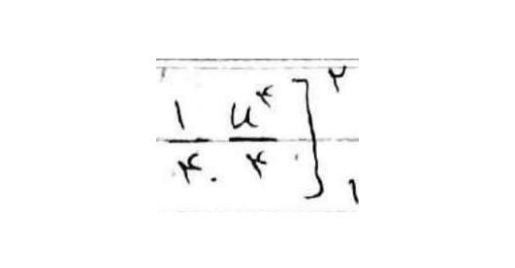

🔹 **Predicted LaTeX Code:**
<s>\frac{1}{4}\frac{u^4}{4}|_1^2</s>

🔹 **Rendered LaTeX Formula:**


<IPython.core.display.Math object>

In [ ]:
# 1️⃣ Upload Image
uploaded = files.upload()  # Upload image
image_path = list(uploaded.keys())[0]  # Extract image path

# 2️⃣ Image Processing
from PIL import Image
import torchvision.transforms as TT
import torch
import matplotlib.pyplot as plt
from IPython.display import display, Math

image = Image.open(image_path).convert("L")  # Convert to grayscale
transform = TT.Compose([
    TT.Grayscale(num_output_channels=1),
    TT.Resize((256, 512)),  # Resize to 256x512
    TT.ToTensor(),
    TT.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])
img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# 3️⃣ Model Prediction
with torch.no_grad():  # No gradient computation required
    pred = lit_model.model.predict(img_tensor)[0]  # Get the prediction for the image

# 4️⃣ Convert Output to LaTeX
decoded = []
for j in pred.tolist():
  if j != 1:  # If it's not the end token
    decoded.append(lit_model.tokenizer.id_to_token(j))
  else:  # End token
    decoded.append(lit_model.tokenizer.id_to_token(j))
    break
decoded_str = "".join(decoded)  # Join the tokens to form LaTeX string

# 5️⃣ Display Image and LaTeX Formula
plt.imshow(image, cmap="gray")  # Display image in grayscale
plt.axis("off")  # Remove axis
plt.show()  # Show image

print("🔹 **Predicted LaTeX Code:**")
print(decoded_str)  # Print predicted LaTeX code

print("\n🔹 **Rendered LaTeX Formula:**")
display(Math(decoded_str))  # Render LaTeX formula


# **🔴Feature map**

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_single_feature_map(image_tensor, feature_maps):
    """
    Display the input image alongside a single averaged feature map.

    :param image_tensor: The input test image from the DataLoader (Tensor of shape 1, C, 256, 512).
    :param feature_maps: The feature maps from the intermediate layers of ResNet (Tensor of shape B, 256, H, W).
    """
    # Convert Tensor to NumPy (shape: H, W, C)
    img = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    img = np.uint8(img * 255)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for heatmap overlay

    # Compute the mean feature map across all channels to generate a single visualization
    feature_map = feature_maps[0].mean(dim=0).detach().cpu().numpy()

    # Resize the feature map to match the input image size
    feature_map = cv2.resize(feature_map, (512, 256))
    # feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())  # Normalize

    # Generate a heatmap from the feature map
    heatmap = cv2.applyColorMap(np.uint8(255 * feature_map), cv2.COLORMAP_VIRIDIS)
    overlayed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the original image and the feature map overlay
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed)
    plt.title("Averaged Feature Map")
    plt.show()


In [ ]:
def process_one_test_image(model, test_dataloader, device="cuda"):
    """
    Run the model on a single test image and visualize a single averaged feature map.

    :param model: The ResNetTransformer model.
    :param test_dataloader: The DataLoader containing test images.
    :param device: Run on 'cuda' or 'cpu'.
    """
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            image, _ = batch  # Fetch a single test image (labels not needed)
            image = image.to(device)

            # Pass the image through the model and retrieve feature maps
            _, feature_maps = model.encode(image)

            # Display only one averaged feature map
            visualize_single_feature_map(image.cpu(), feature_maps.cpu())
            break  # Process only one image

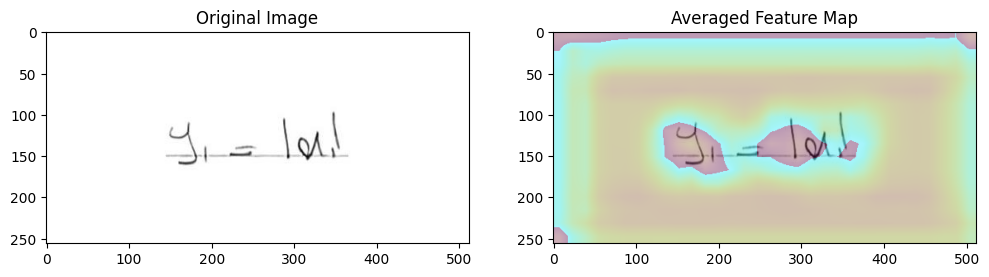

In [ ]:
process_one_test_image(lit_model.model, test_loader, device="cuda")